In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Import necessary packages
%matplotlib inline
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time

In [ ]:
from torchvision import datasets, transforms

#torchvision.transforms() - Composes several transforms together.
#transforms.ToTensor() — converts the image into numbers, that are understandable by the system. It separates the image into three color channels (separate images): red, green & blue. Then it converts the pixels of each image to the brightness of their color between 0 and 255. These values are then scaled down to a range between 0 and 1. The image is now a Torch Tensor.
#transforms.Normalize() — normalizes the tensor with a mean and standard deviation which goes as the two parameters respectively.

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('drive/My Drive/mnist/MNIST_data/', download=True, train=True, transform=transform)
valset = datasets.MNIST('drive/My Drive/mnist/MNIST_data/', download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True, num_workers=0)


In [ ]:
#Exploring The Data

trainexamples = enumerate(trainloader)
tbatch_idx, (example_tdata, example_ttargets) = next(trainexamples)


#check the shape of the images and the labels.
# which suggests that there are 64 images in each batch and each image has a dimension of 28 x 28 pixels.
# Similarly, the labels have a shape as torch.Size([64]).64 images should have 64 labels respectively.
example_tdata.shape, example_ttargets.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

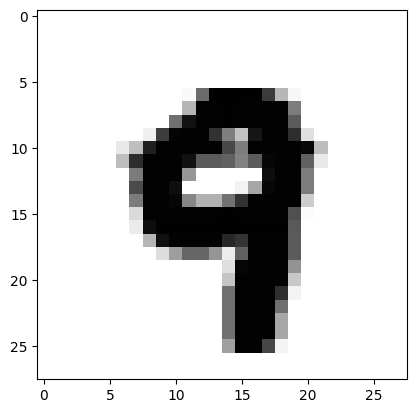

In [ ]:
#plotting the image

plt.imshow(example_tdata[7].numpy().squeeze(), cmap='gray_r');

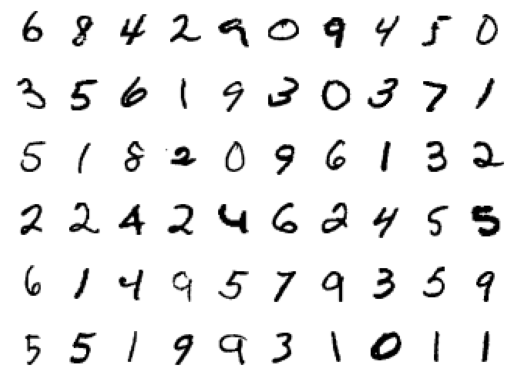

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(example_tdata[index].numpy().squeeze(), cmap='gray_r')


In [ ]:
#checking the shape of the validation dataset

examples = enumerate(valloader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape


torch.Size([64, 1, 28, 28])

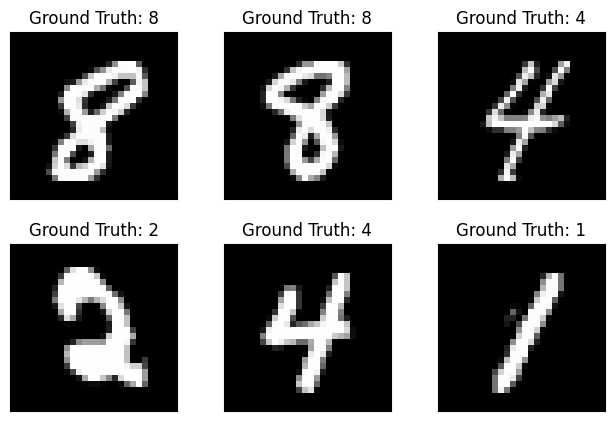

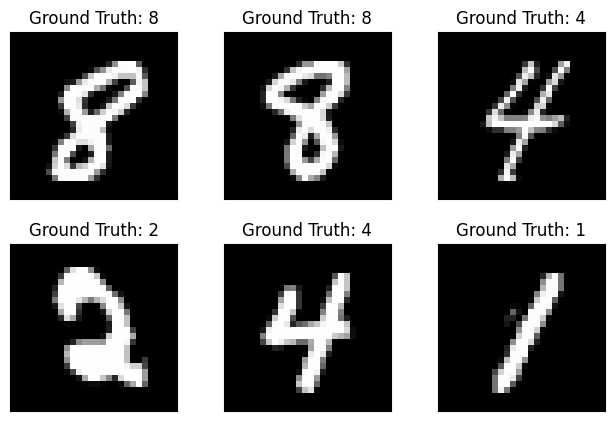

In [ ]:
#plotting the images against the ground truth (labels)
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
#Building the Network
#We'll use two 2-D convolutional layers followed by two fully-connected (or linear) layers.
#we'll choose rectified linear units As activation function
#and for regularization we'll use two dropout layers.

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

learning_rate = 0.01
momentum = 0.5

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window  If the size is a square, you can specify with a single numbe
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim = 1)

#creating the object on the  (model)class
network = Net()

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [ ]:
print(network)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [ ]:
#Training the Model
#defining epoch
n_epochs = 3


train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trainloader.dataset) for i in range(n_epochs + 1)]


In [ ]:
#Defining the function to traing the model

#First we make sure our network is in training mode.
#We will iterate over all training data once per epoch. and DataLoader will load the  individual batches.
#set the gradients to zero using optimizer.zero_grad() since PyTorch by default accumulates gradients.
#Produce the output of our network (forward pass) and compute a negative log-likelihodd loss between the output and the ground truth label.
#The backward() call we now collect a new set of gradients which we propagate back into each of the network's parameters using optimizer.step().


def train(epoch):
  network.train()

  for batch_idx, (data, target) in enumerate(trainloader):
    #we need to manually set the gradients to zero using optimizer.zero_grad() since PyTorch by default accumulates gradients.
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(trainloader.dataset),100. * batch_idx / len(trainloader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append((batch_idx*64) + ((epoch-1)*len(trainloader.dataset)))

      #state_dict() - load their internal state using.
      torch.save(network.state_dict(), '/model.pth')
      torch.save(optimizer.state_dict(), '/optimizer.pth')

In [ ]:
# defining the function to test
# In this function, we sum up the test loss and compute the accuracy of the network.

def test():
  network.eval()
  test_loss = 0
  correct = 0

  #no_grad() :- avoid storing the computations done producing the output of our network in the computation graph.
  with torch.no_grad():
    for data, target in valloader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(valloader.dataset)
  print('test_loss', test_loss)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(valloader.dataset), 100. * correct / len(valloader.dataset)))

In [ ]:
log_interval = 10

#test():-call before we loop over n_epochs to evaluate model with randomly initialized parameters.
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

test_loss 0.04157732908204198

Test set: Avg. loss: 0.0416, Accuracy: 9869/10000 (99%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.262804
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.092611
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.040855
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.139621
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.054803
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.108655
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.077022
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.129633
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.173598
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.139648
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.149874
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.160301
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.361856
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.240923
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.158590
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.234458
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.090475
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.253710
Train Epoch: 1 [11520/60000 (19%)]	Loss: 

In [ ]:
test_counter, test_losses

([0, 60000, 120000, 180000],
 [0.04157732908204198,
  0.043548444574791935,
  0.040198156452924017,
  0.04097888042703271])

In [ ]:
#defining the function for viewing an image and it's predicted classes.

def view_classify(img, ps):
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

In [ ]:
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = network(example_data[2])
# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.numpy()[0])

print("Predicted Digit =", probab.index(max(probab)))

Predicted Digit = 4


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


In [ ]:
example_targets

tensor([8, 8, 4, 2, 4, 1, 8, 3, 1, 4, 5, 4, 3, 3, 9, 1, 1, 6, 1, 4, 3, 1, 2, 7,
        2, 7, 1, 1, 3, 2, 6, 9, 6, 1, 8, 4, 7, 2, 7, 2, 7, 0, 6, 2, 6, 6, 1, 4,
        1, 0, 1, 3, 2, 4, 6, 9, 7, 4, 2, 3, 7, 7, 4, 5])

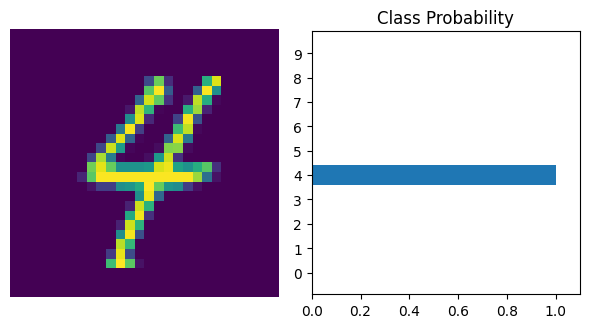

In [ ]:
view_classify(example_data[2].view(1, 28, 28), ps)

In [ ]:
#Model Evaluation

correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i]
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = network(img)

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))


Number Of Images Tested = 10000

Model Accuracy = 0.9866


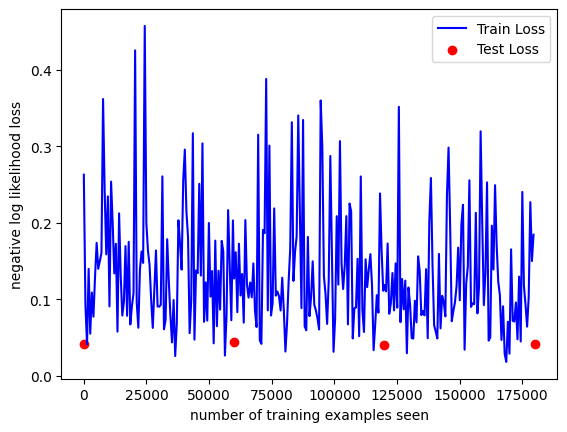

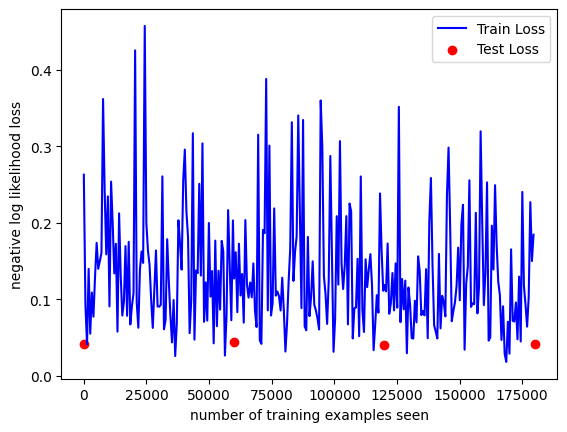

In [ ]:
#Evaluating the Model's Performance

fig = plt.figure()

plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')

plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig